### UMAP Visualization of CFPB Glove-Doc2Vec Space


In [12]:
import pandas as pd
import numpy as np
import os
import keras



os.chdir("/home/spenser/Downloads/case_study")

In [13]:
CFPB_1 = pd.read_csv("cfpb_1.csv")

CFPB_2 = pd.read_csv("cfpb_2.csv", header = None)
CFPB_2.columns = ['complaint_id', 'text']

CFPB_3 = pd.read_csv("cfpb_3.csv", header = None)
CFPB_3.columns = ['complaint_id', 'text']

CFPB_4 = pd.read_csv("cfpb_4.csv", header = None)
CFPB_4.columns = ['complaint_id', 'text']

CFPB_5 = pd.read_csv("cfpb_5.csv", header = None)
CFPB_5.columns = ['complaint_id', 'text']

CFPB_text = pd.concat([CFPB_1, CFPB_2, CFPB_3, CFPB_4, CFPB_5])

file_no_text = pd.read_csv("cfpb_triage_case_study_notext.csv")

CFPB_prod = pd.read_csv("Consumer_Complaints.csv")

#names = full_CFPB_data.columns.tolist()
#names[names.index('Complaint ID')] = 'complaint_id'
#full_CFPB_data.columns = names

/home/spenser/.conda/envs/gpu/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4,5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
CFPB_Case_Study_Joined = file_no_text.merge(CFPB_text, on = 'complaint_id', how ='left')

In [15]:

print(CFPB_Case_Study_Joined["product_group"].value_counts())




credit_reporting    81407
debt_collection     61531
mortgage            40313
loan                31059
credit_card         29569
bank_service        20083
money_transfers      4739
Name: product_group, dtype: int64


In [16]:
import string 
#text already appears to be cleansed ... but, just making sure. limited pre-processing - these assumptions can be played around with when we build classifiers

CFPB_Case_Study_Joined["text_lower"] = CFPB_Case_Study_Joined["text"].str.lower()

CFPB_Case_Study_Joined["text_lower"] = CFPB_Case_Study_Joined["text_lower"].str.replace(r'\nRevision: (\d+)\n', '') #remove digits

def remove_punctuations(text):

    for punctuation in string.punctuation:

        text = text.replace(punctuation, '')

    return text


CFPB_Case_Study_Joined["text_clean"] = CFPB_Case_Study_Joined['text_lower'].apply(remove_punctuations)  #remove punctuation


#Adding this due to finding below that pre-cleansed text is corrupt. (contains cases like can t) . Remove single stand-alone characters. ("a", "e", etc)

CFPB_Case_Study_Joined["text_clean"] = CFPB_Case_Study_Joined["text_clean"].str.replace(r'\b(?<=)[a-z](?=)\b', '') #remove single stand-alone characters.

 

In [17]:
CFPB_Case_Study_Joined["text_clean"].head()

0    on my check was debited from my checking accou...
1     opened  bank of the the west account the acco...
2    wells fargo in nj opened  business account wit...
3     hold was placed on my saving account because ...
4    dear cfpb  need to send  major concern complai...
Name: text_clean, dtype: object

In [18]:
cfpb_pd = CFPB_Case_Study_Joined

cfpb_pd["word_count"] = cfpb_pd["text_clean"].str.count(' ') + 1
cfpb_pd["word_count"] = cfpb_pd["word_count"].astype(int)

cfpb_pd = cfpb_pd[cfpb_pd["word_count"] >= 10]
print(len(cfpb_pd), "Complaints")

266271 Complaints


In [19]:
from gensim.scripts.glove2word2vec import glove2word2vec
import gensim
from gensim.test.utils import get_tmpfile


glove_path = "/home/spenser/Downloads/case_study/glove.6B.300d.txt"
tmp_file = get_tmpfile("test_word2vec.txt")

_ = glove2word2vec(glove_path, tmp_file)

word2vec = gensim.models.KeyedVectors.load_word2vec_format(tmp_file)


In [20]:
cfpb_pd_sample = cfpb_pd.sample(n=50000, random_state=1)

#Setting sample to full size

#cfpb_pd_sample = cfpb_pd

In [21]:

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = cfpb_pd_sample['text_clean'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)


embeddings = get_word2vec_embeddings(word2vec,  cfpb_pd_sample)


In [22]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap
%matplotlihttp://localhost:8890/notebooks/Untitled109.ipynb?kernel_name=gpu#b inline
sns.set(style='white', rc={'figure.figsize':(12,8)})

UsageError: Line magic function `%matplotlihttp://localhost:8890/notebooks/Untitled109.ipynb?kernel_name=gpu#b` not found.


In [23]:
fit = umap.UMAP()
%time u = fit.fit_transform(embeddings)

/home/spenser/.conda/envs/gpu/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


CPU times: user 1min 24s, sys: 768 ms, total: 1min 24s
Wall time: 1min 11s


In [24]:
cfpb_pd_sample['product_group'].unique()

array(['loan', 'credit_reporting', 'mortgage', 'debt_collection',
       'credit_card', 'money_transfers', 'bank_service'], dtype=object)

In [25]:

product = pd.Categorical(cfpb_pd_sample['product_group']).codes


def draw_umap(n_neighbors=15, min_dist=0.1, n_components=3, metric='cosine', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(embeddings);
    fig = plt.figure()
    plt.gcf().set_size_inches((20, 20))    
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=product)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c= product)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=product)
    plt.title(title, fontsize=18)

/home/spenser/.conda/envs/gpu/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2356 separate connected components using meta-embedding (experimental)
  n_components
/home/spenser/.conda/envs/gpu/lib/python3.7/site-packages/umap/spectral.py:182: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/spenser/.conda/envs/gpu/lib/python3.7/site-packages/umap/spectral.py:182: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/spenser/.conda/envs/gpu/lib/python3.7/site-packages/

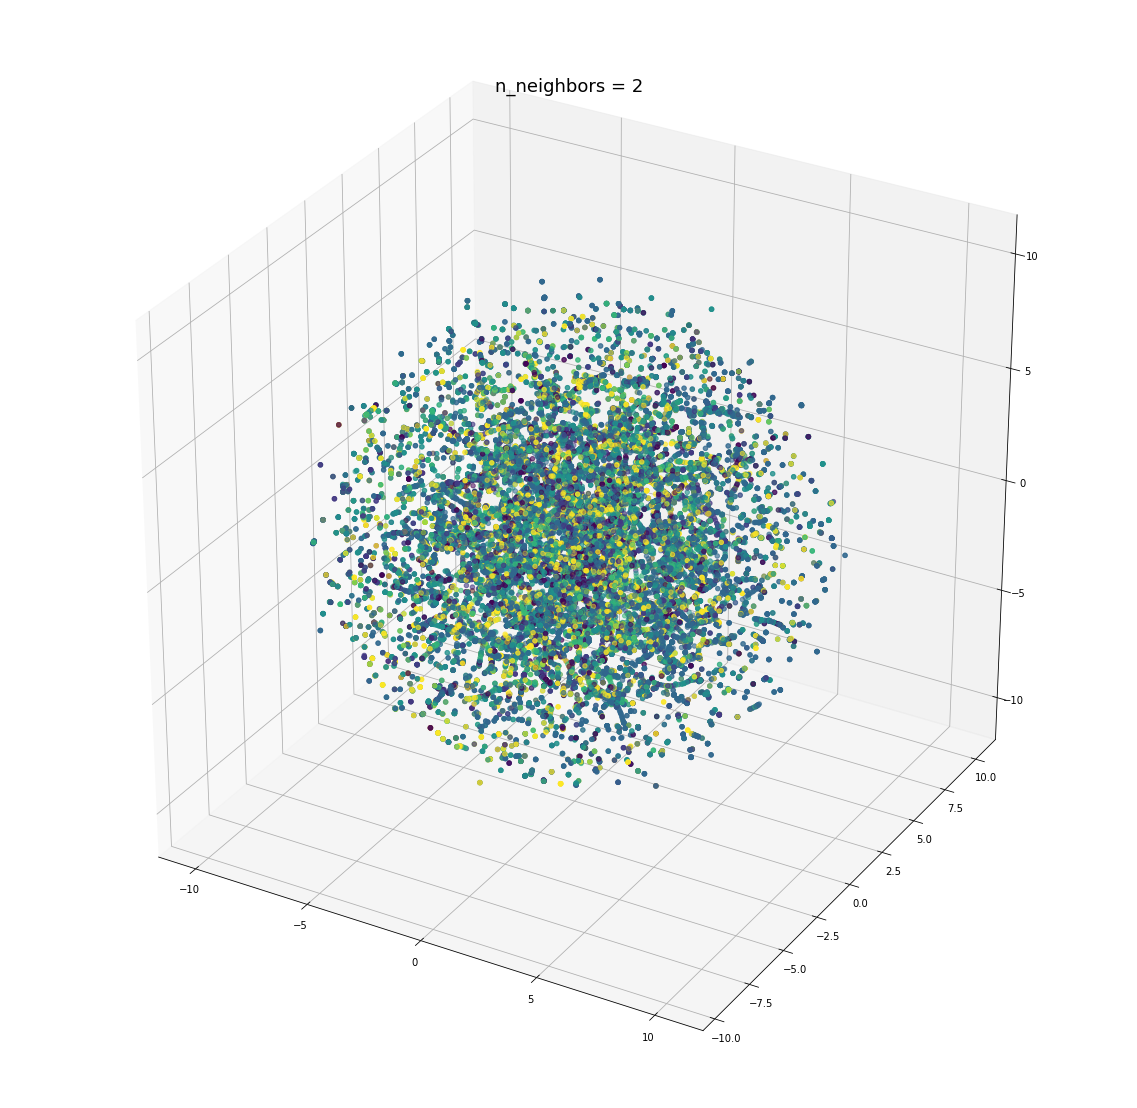

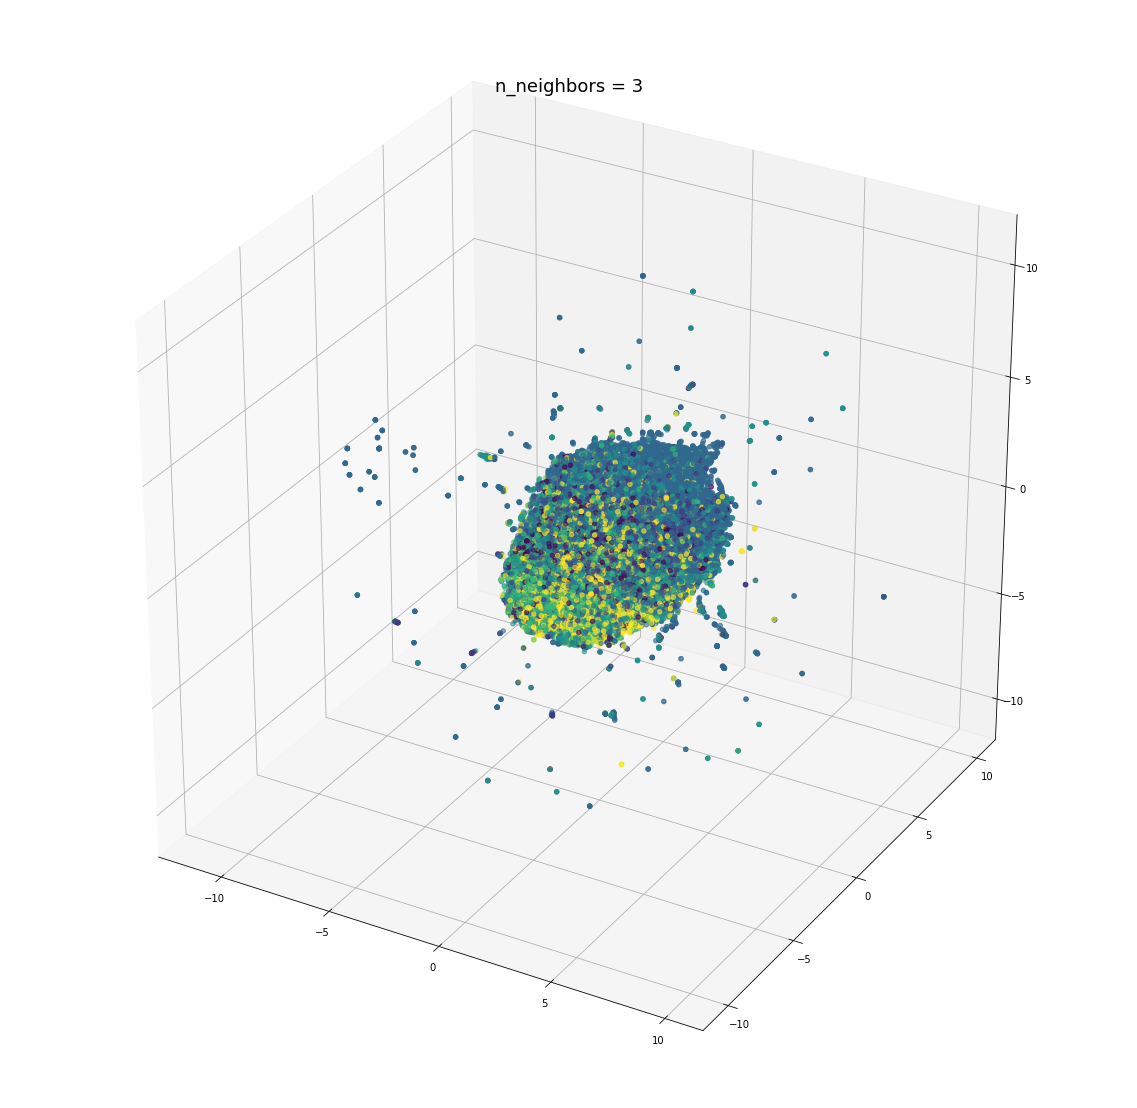

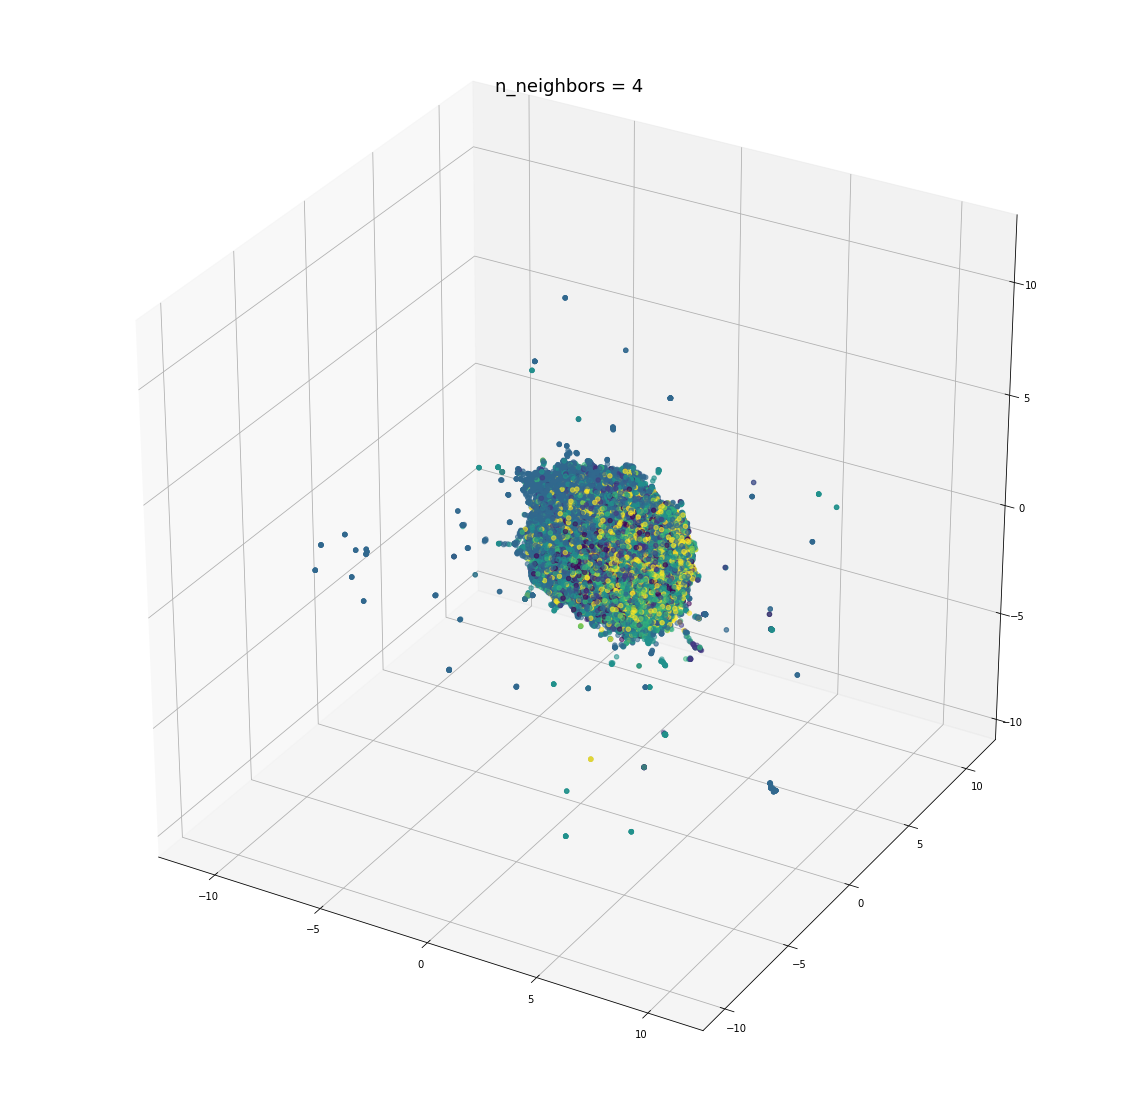

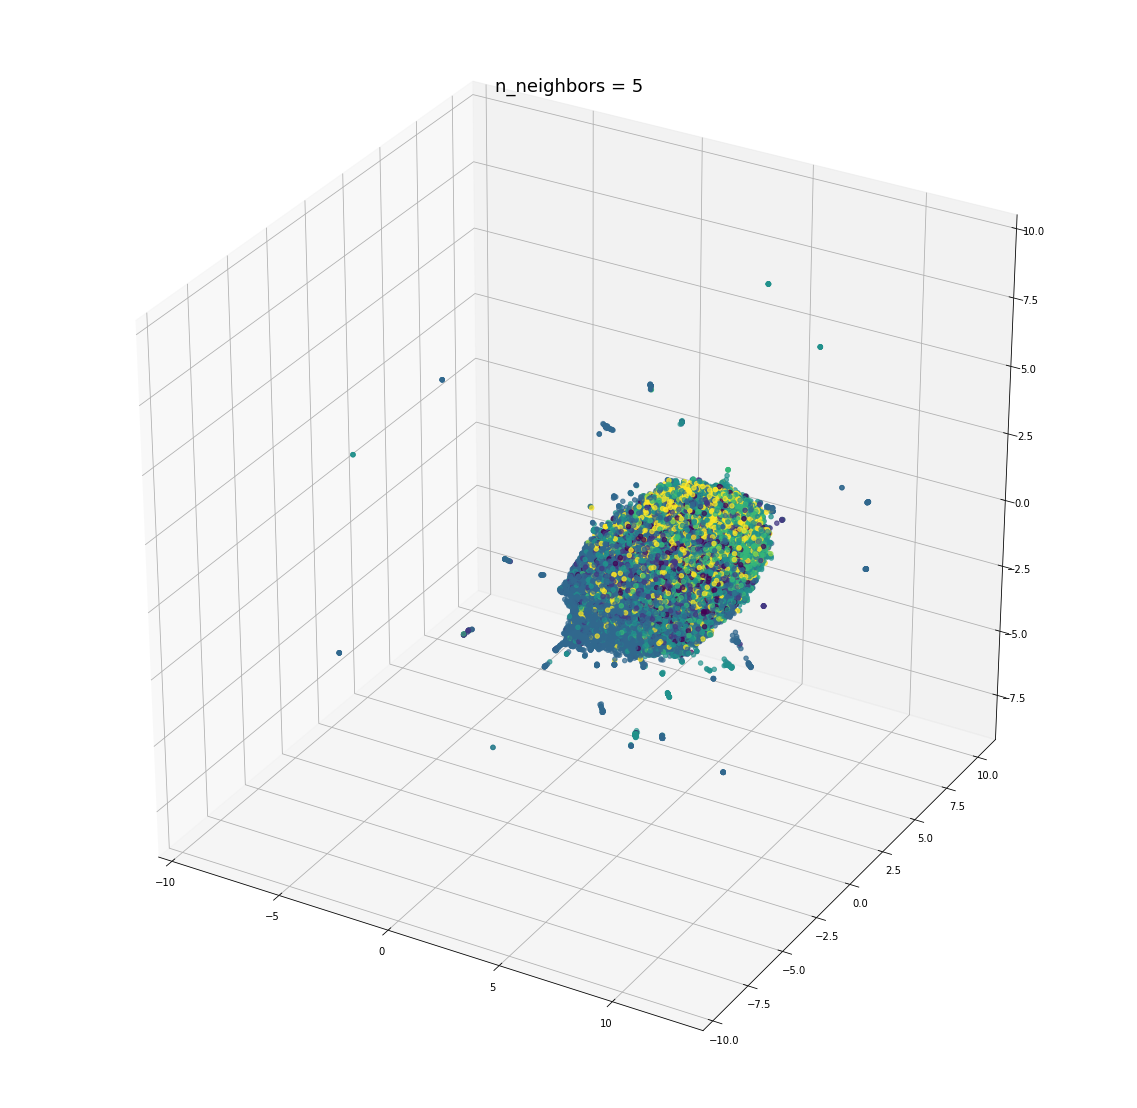

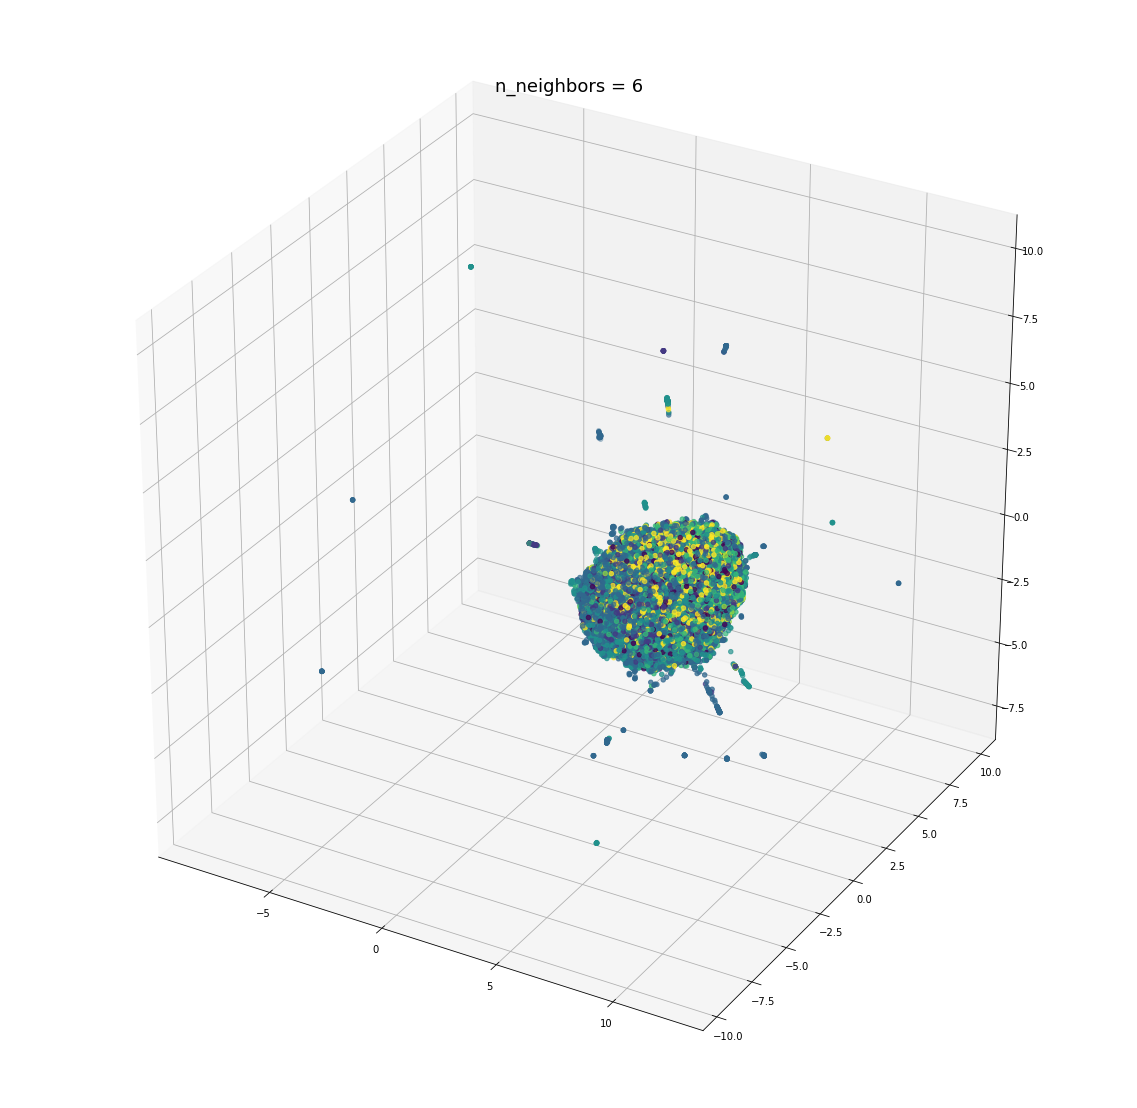

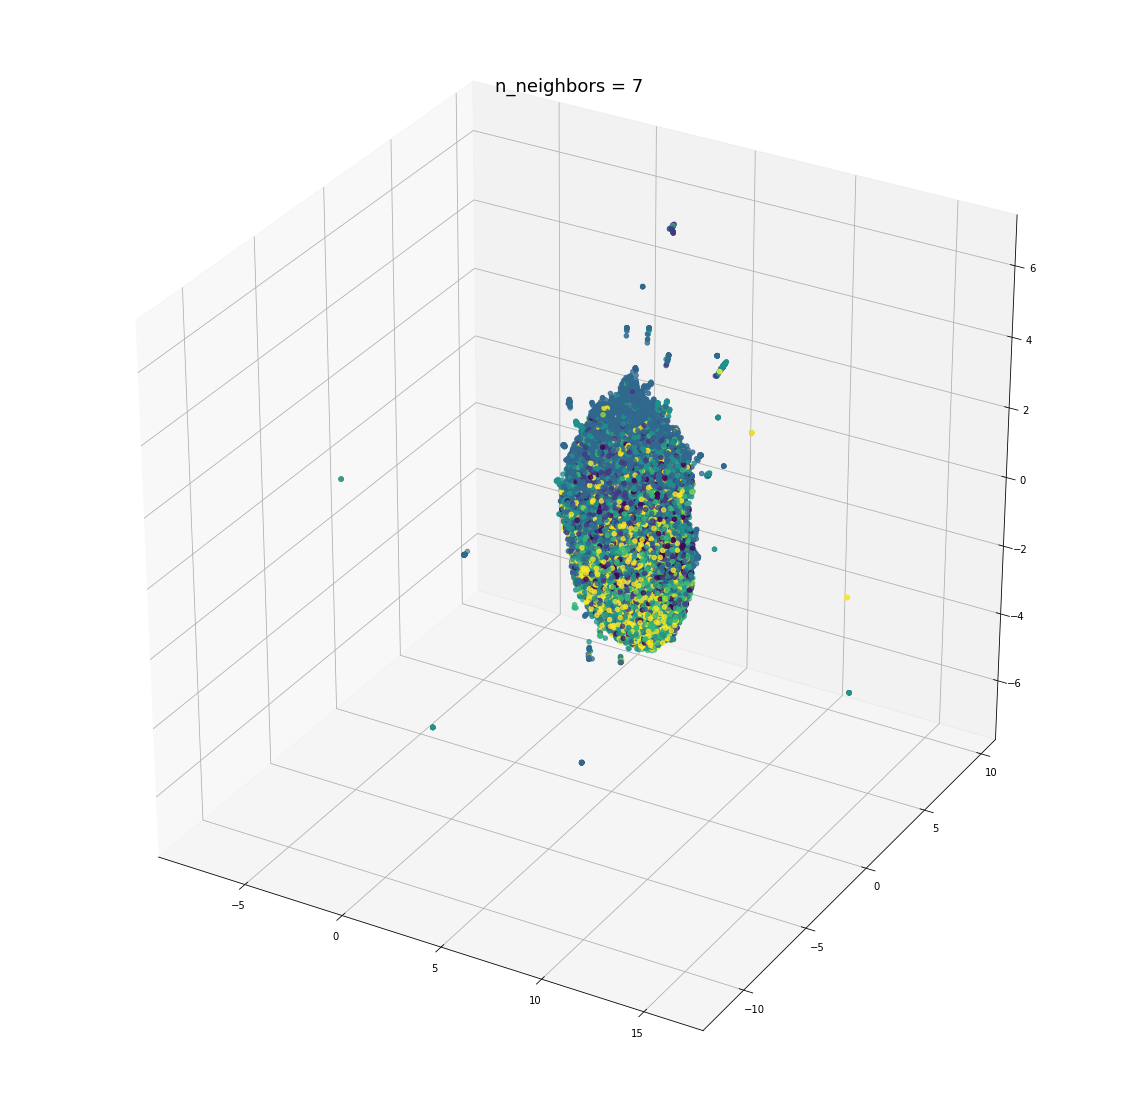

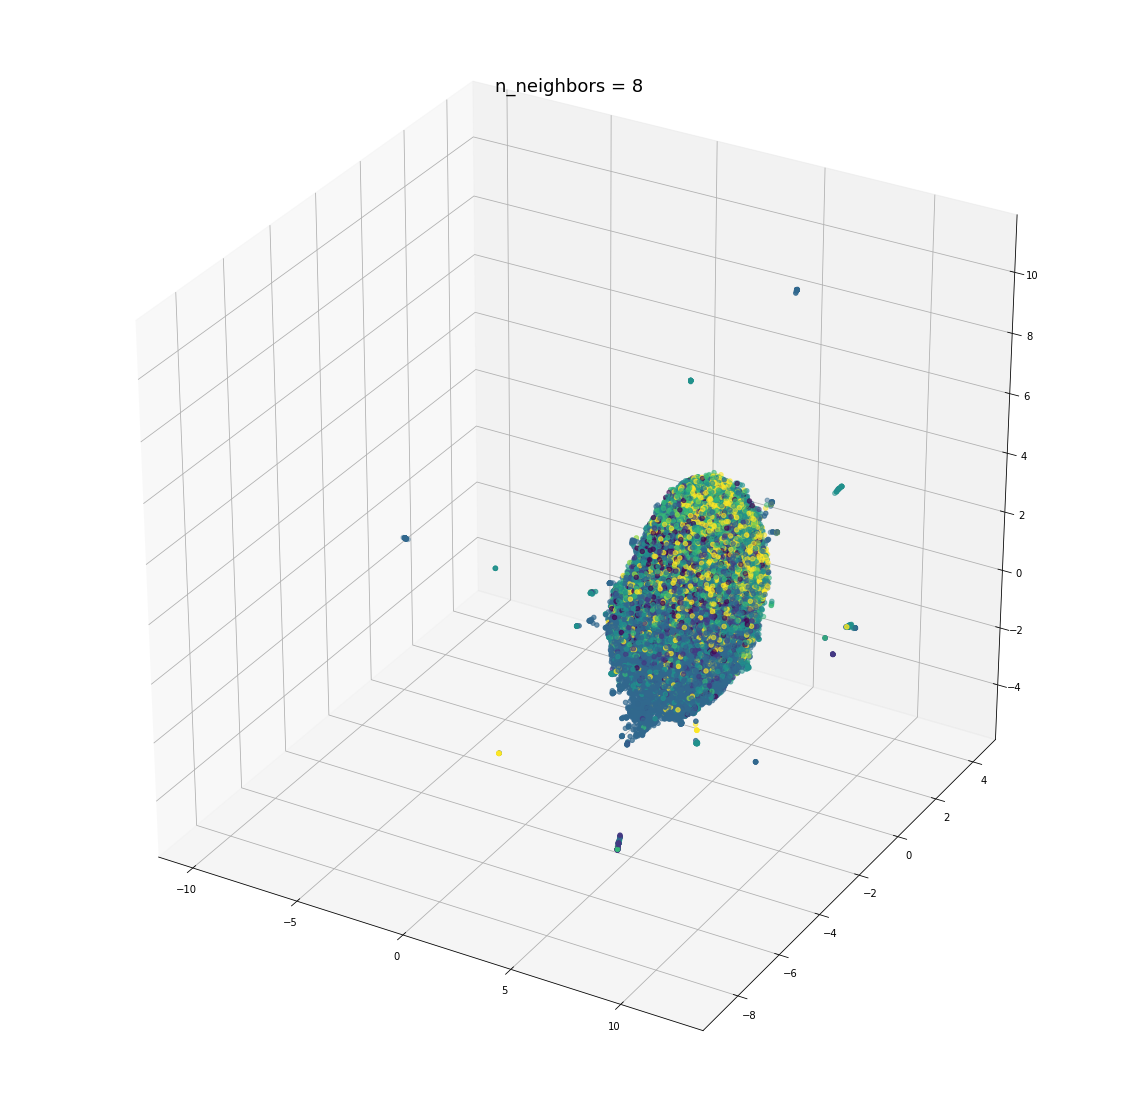

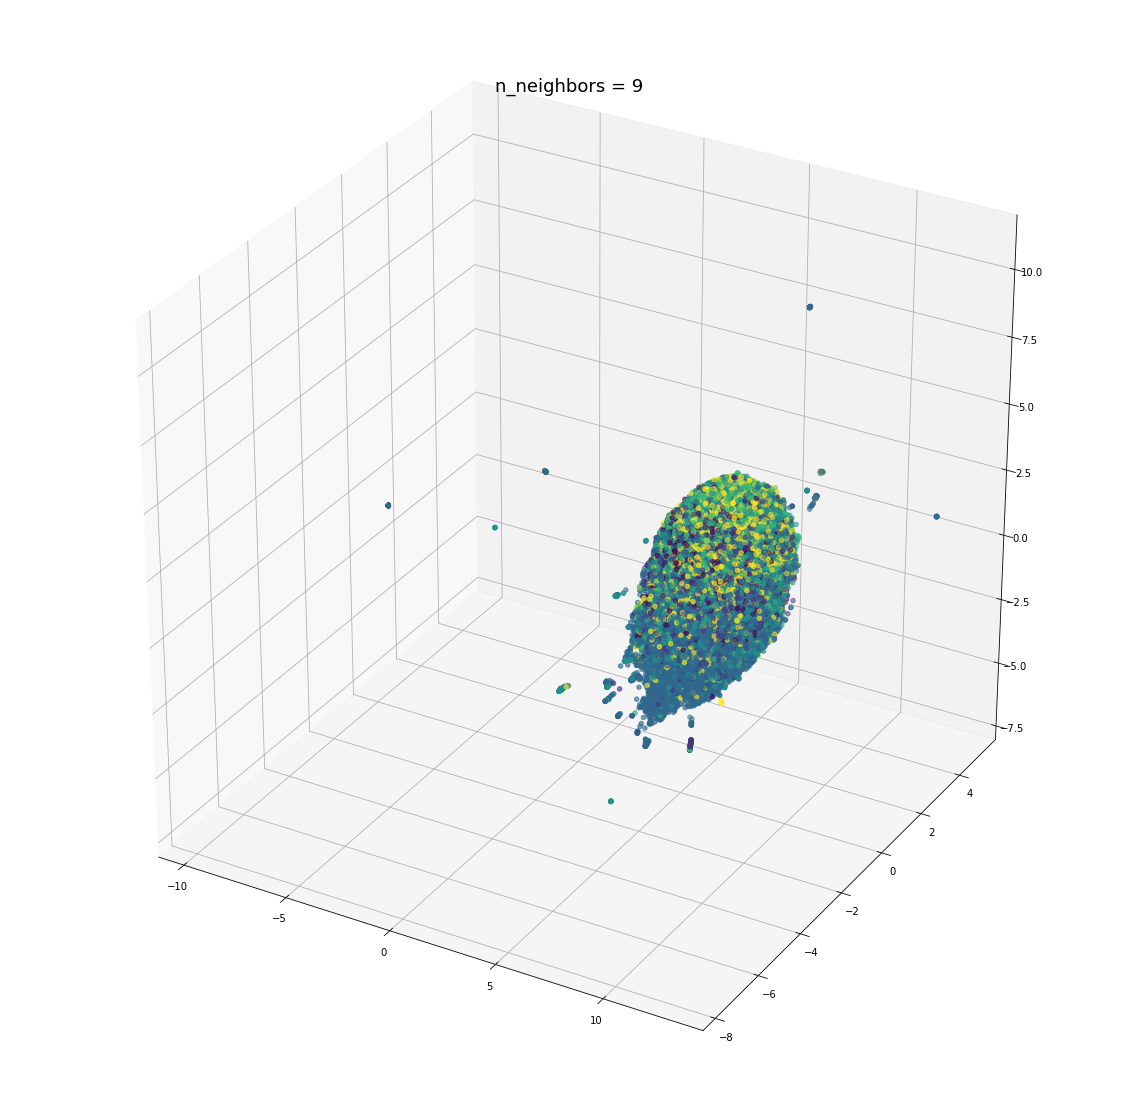

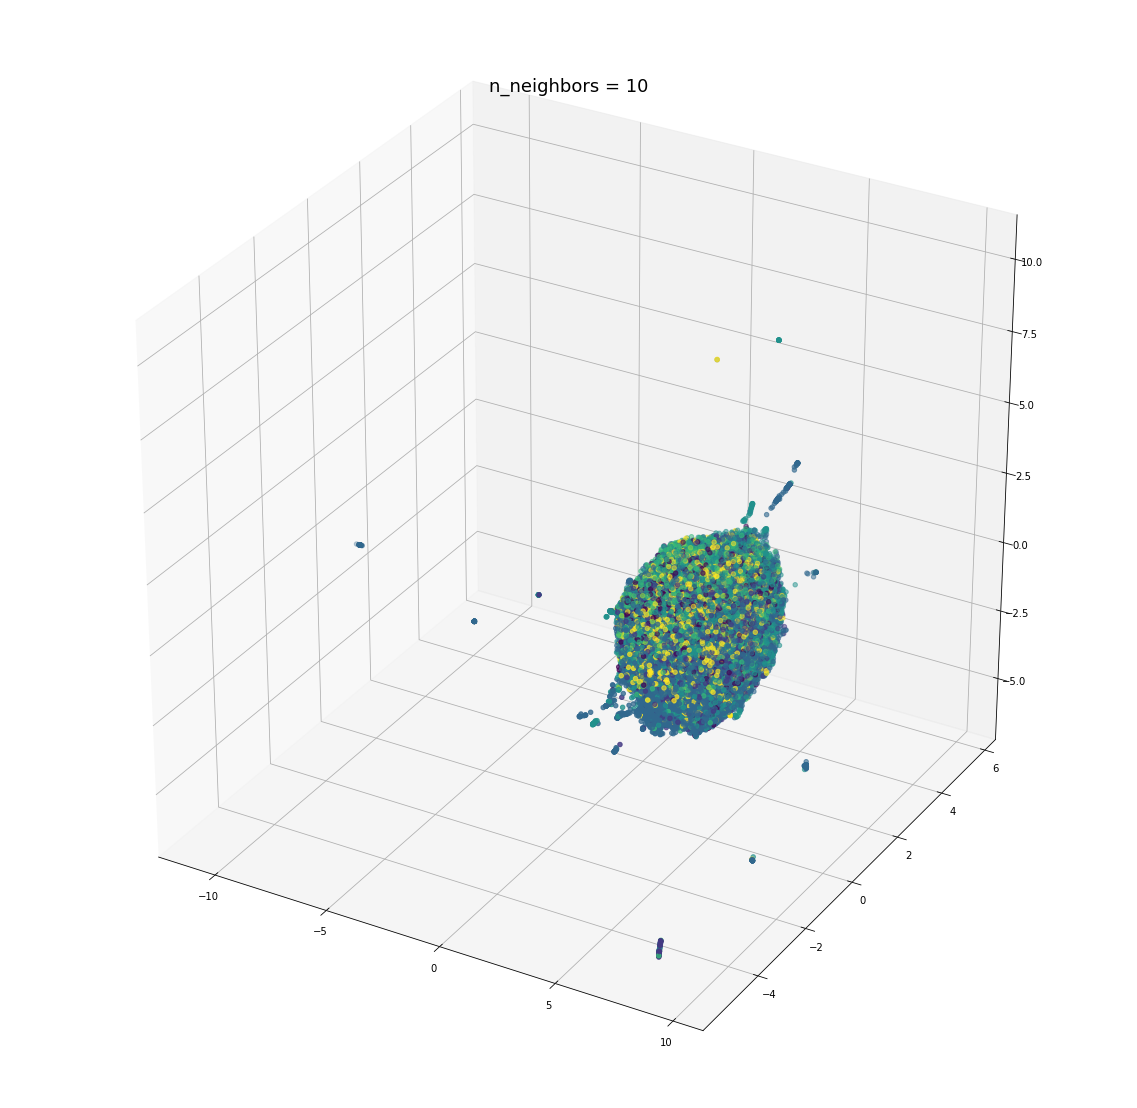

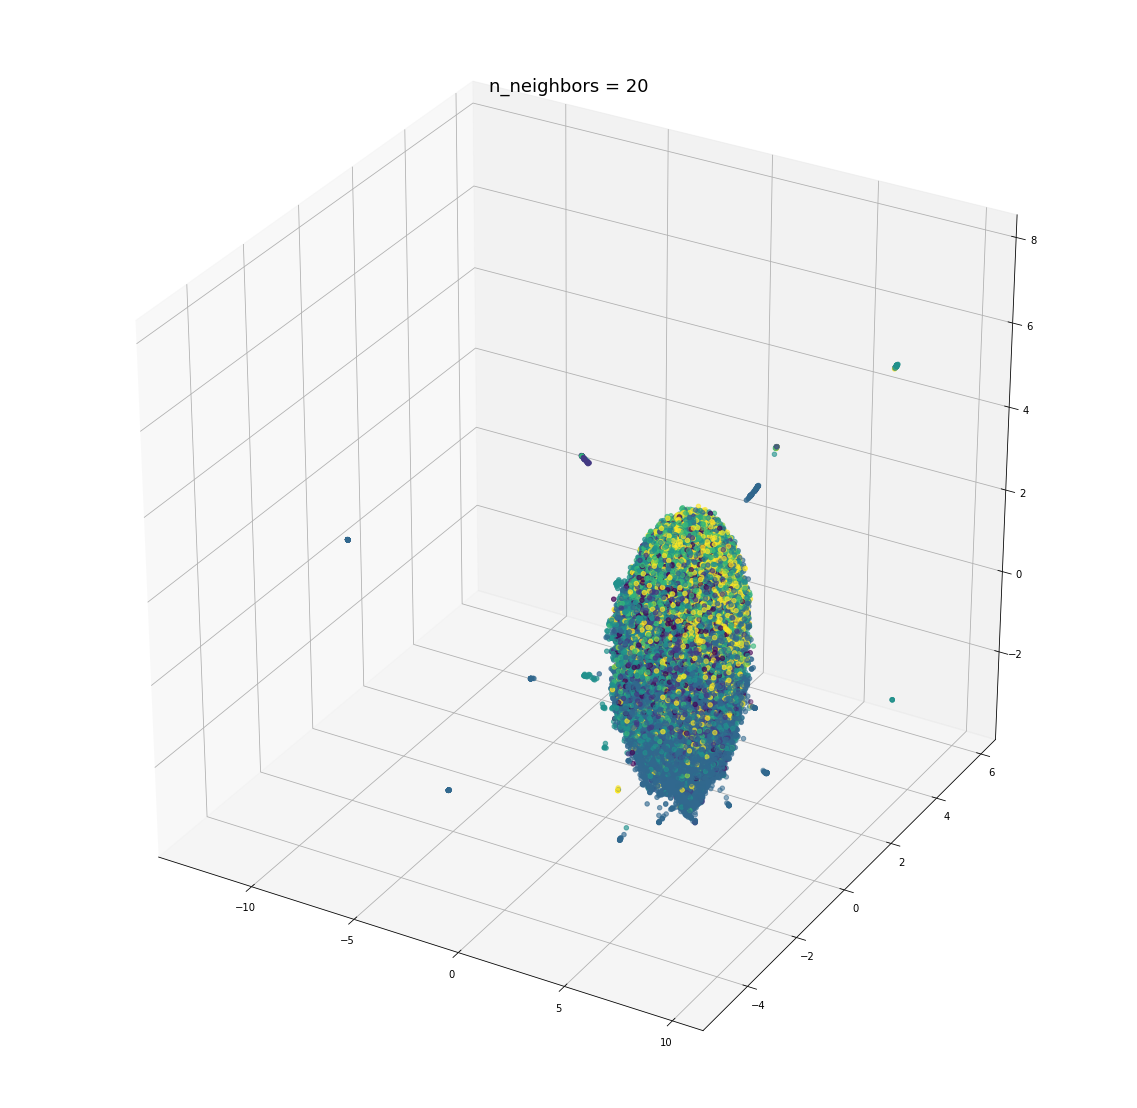

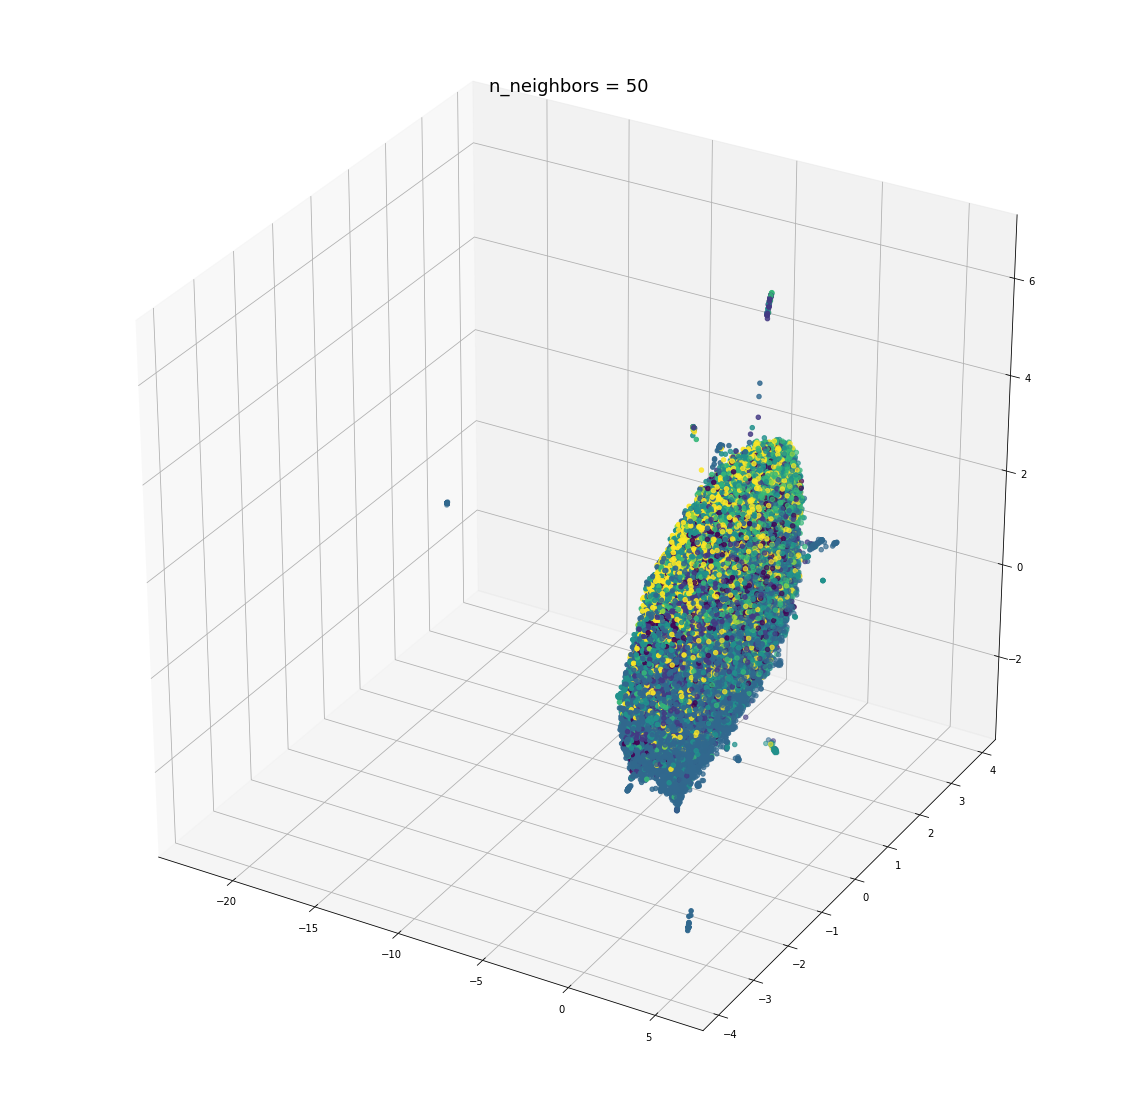

In [26]:
for n in (2, 3, 4,  5, 6, 7, 8, 9, 10, 20, 50):
    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))